In [1]:
import numpy as np
from skimage import color, filters
import matplotlib.pyplot as plt
from skimage import io
import cv2 as cv


#II. Nội dung:


##1. Seam Carving:


a) Tính toán năng lượng của ảnh:


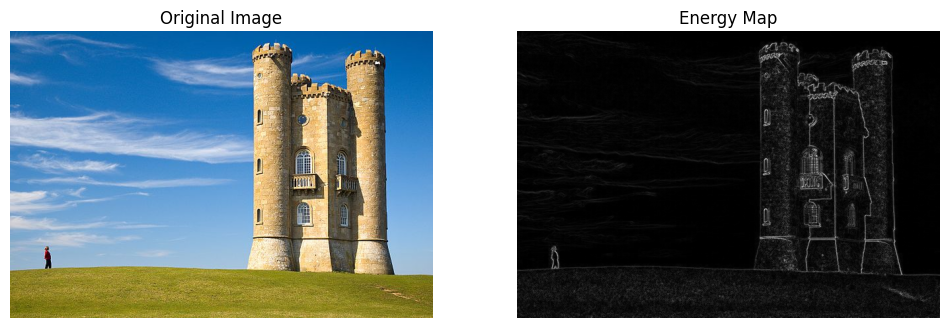

In [2]:

def energy_function(image):

	H, W, _ = image.shape
	out = np.zeros((H, W))

	image = color.rgb2gray(image)
	out_y, out_x = np.gradient(image)
	out = abs(out_y)+abs(out_x)

	return out
image_path = '/content/castle.jpg'
image = io.imread(image_path)

energy_map = energy_function(image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(image)
ax1.set_title("Original Image")
ax1.axis("off")

ax2.imshow(energy_map, cmap='gray')
ax2.set_title("Energy Map")
ax2.axis("off")

plt.show()

b) Tìm chi phí thấp nhất tại từng điểm ảnh:


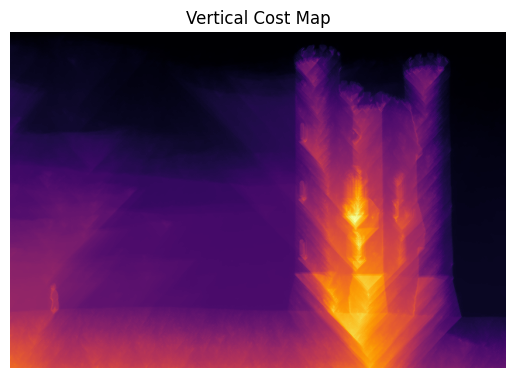

In [3]:
def compute_cost(image, energy, axis=1):

	energy = energy.copy()

	if axis == 0:
		energy = np.transpose(energy, (1, 0))

	H, W = energy.shape

	cost = np.zeros((H, W))
	paths = np.zeros((H, W), dtype=int)

	cost[0] = energy[0]
	paths[0] = 0

	for i in range(1,H):
		left_neighbor = np.insert(cost[i-1,0:W-1], 0, 1e10)
		upper_neighbor = cost[i-1]
		right_neighbor = np.insert(cost[i-1,1:W], W-1, 1e10)
		pixel_neighbors = np.vstack([left_neighbor,upper_neighbor,right_neighbor])
		cost[i] = energy[i]+np.min(pixel_neighbors, axis=0)
		paths[i] = np.argmin(pixel_neighbors, axis=0)-1

	if axis == 0:
		cost = np.transpose(cost, (1, 0))
		paths = np.transpose(paths, (1, 0))

	assert np.all(np.any([paths == 1, paths == 0, paths == -1], axis=0)), \
		   "paths contains other values than -1, 0 or 1"

	return cost, paths

img = io.imread('/content/castle.jpg')
energy = energy_function(img)


vcost, _ = compute_cost(img, energy, axis=1)
plt.title('Vertical Cost Map')
plt.axis('off')
plt.imshow(vcost, cmap='inferno')
plt.show()

c) Tìm đường seam:


Seam Energy 2.4323654901960783


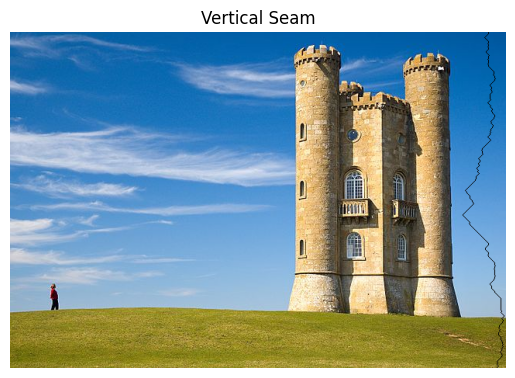

In [19]:
def backtrack_seam(paths, end):
	H, W = paths.shape
	seam = np.zeros(H, dtype=int)

	seam[H-1] = end

	for i in range(H-2,0,-1):
		seam[i] = seam[i+1]+paths[i+1,seam[i+1]]
	seam[0] = seam[1]+paths[1,seam[1]]

	assert np.all(np.all([seam >= 0, seam < W], axis=0)), "seam contains values out of bounds"
	return seam


vcost, vpaths = compute_cost(img, energy)

end = np.argmin(vcost[-1])
seam_energy = vcost[-1, end]
seam = backtrack_seam(vpaths, end)

print('Seam Energy', seam_energy)

vseam = np.copy(img)
for row in range(vseam.shape[0]):
  vseam[row, seam[row], :] = np.array([1.0, 0, 0])

plt.title('Vertical Seam')
plt.axis('off')
plt.imshow(vseam)
plt.show()


d) Loại bỏ đường seam:


In [20]:
def remove_seam(image, seam):
  if len(image.shape) == 2:
    image = np.expand_dims(image, axis=2)
  out = None
  H, W, C = image.shape
  out = np.zeros((H, W-1, C), dtype=type(image[0, 0, 0]))

  for i in range(H):
    out[i, 0:seam[i], 0:C] = image[i, 0:seam[i], 0:C].copy()
    out[i, seam[i]:, 0:C] = image[i, seam[i]+1:, 0:C].copy()

  out = np.squeeze(out)
  return out

● Cài đặt hàm reduce để giảm kích thước ảnh:


In [21]:
def reduce(image, size, axis=1, efunc=energy_function, cfunc=compute_cost):
  out = np.copy(image)
  if axis == 0:
    out = np.transpose(out, (1, 0, 2))
  H = out.shape[0]
  W = out.shape[1]

  assert W > size, "Size must be smaller than %d" % W

  assert size > 0, "Size must be greater than zero"

  loop = W - size
  for i in range(loop):
    _cost, _path = cfunc(out, efunc(out))
    _seam = backtrack_seam(_path, np.argmin(_cost[-1]))
    out = remove_seam(out, _seam).copy()
  assert out.shape[1] == size, "Output doesn't have the right shape"

  if axis == 0:
    out = np.transpose(out, (1, 0, 2))

  return out

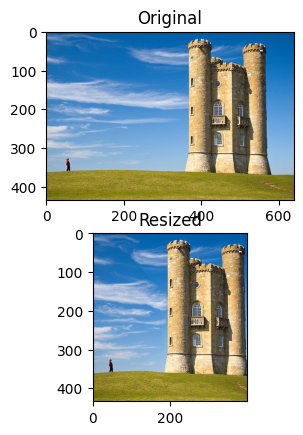

In [22]:
H, W, _ = img.shape
W_new = 400

out = reduce(img, W_new)

# print("Reducing width from %d to %d: %f seconds." %(W, W_new, end - start))

plt.subplot(211)
plt.title('Original')
plt.imshow(img)

plt.subplot(212)
plt.title('Resized')
plt.imshow(out)
plt.show()


##2. Các phương pháp trích xuất đặt trưng:
a) Sift:

In [23]:
def detect_keypoints(magnitude, threshold=10.0, edge_size=8):
  keypoints = []
  h, w = magnitude.shape
  for y in range(edge_size, h-edge_size):
    for x in range(edge_size, w-edge_size):
      if magnitude[y, x] > threshold:
        keypoints.append((x, y))
  return keypoints

In [24]:
def compute_histogram(patch_ori, patch_mag, bins=8, range_bins=(-180, 180)):
  histogram = [0] * bins
  bin_size = (range_bins[1] - range_bins[0]) / bins

  for i in range(patch_ori.shape[0]):
    for j in range(patch_ori.shape[1]):
      ori = patch_ori[i, j]
      mag = patch_mag[i, j]
      bin_index = int((ori - range_bins[0]) / bin_size)

      bin_index = min(max(bin_index, 0), bins -1)

      histogram[bin_index] += mag

  return histogram

In [25]:
def compute_descriptors(keypoints, magnitude, orentations):
  descriptors = []
  for kp in keypoints:
    y, x = kp
    patch_mag = magnitude[y-8:y+8, x-8:x+8]
    patch_ori = orentations[y-8:y+8, x-8:x+8]
    hist = compute_histogram(patch_ori, patch_mag, bins=8, range_bins=(-180, 180))
    descriptors.append(hist)
  return np.array(descriptors)


In [26]:
def draw_keypoints(image, keypoints):
  img_keypoints = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
  for kp in keypoints:
    cv.circle(img_keypoints, (kp[1], kp[0]), 3, (0, 0, 255), 1)
  return img_keypoints

In [27]:
def compute_gradients(image):
    gx = filters.sobel_h(image)
    gy = filters.sobel_v(image)
    magnitude = np.sqrt(gx**2 + gy**2)
    orientation = np.arctan2(gy, gx) * (180 / np.pi)
    return magnitude, orientation

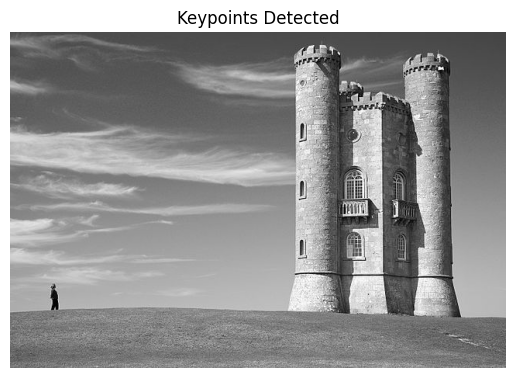

In [28]:
def SIFT():
    imgPath = '/content/castle.jpg'
    imgGray = cv.imread(imgPath, cv.IMREAD_GRAYSCALE)

    if imgGray is None:
        print('Error: Image not found')
        return

    magnitude, orientation = compute_gradients(imgGray)
    keypoints = detect_keypoints(magnitude, threshold=10.0)
    descriptors = compute_descriptors(keypoints, magnitude, orientation)
    imgKeypoints = draw_keypoints(imgGray, keypoints)

    plt.figure()
    plt.imshow(imgKeypoints, cmap='gray')
    plt.title('Keypoints Detected')
    plt.axis('off')
    plt.show()

if __name__ == '__main__':
    SIFT()

In [29]:
def compute_gradients(image):
    ang = 90
    gx = filters.sobel_h(image)
    gy = filters.sobel_v(image)
    magnitude = np.sqrt(gx**2 + gy**2)
    orientation = np.arctan2(gy, gx) * (180 / np.pi)
    orientation = np.degrees(ang) % 180
    return magnitude, orientation

#III. Bài tập:


1. Tạo hàm duplicate_seam (Tương tự hàm remove_seam).


In [30]:
def duplicate_seam(image, seam):
	H, W, C = image.shape
	out = np.zeros((H, W + 1, C), dtype=type(image[0, 0, 0]))
	for i in range(H):
		out[i,0:seam[i]+1,0:C] = image[i,0:seam[i]+1,0:C].copy()
		out[i,seam[i]+1:,0:C] = image[i,seam[i]:,0:C].copy()

	return out


In [31]:
def enlarge_naive(image, size, axis=1, efunc=energy_function, cfunc=compute_cost):

	out = np.copy(image)
	if axis == 0:
		out = np.transpose(out, (1, 0, 2))
	H = out.shape[0]
	W = out.shape[1]
	assert size > W, "size must be greather than %d" % W
	loop = size - W
	for i in range(loop):
		_cost, _path = cfunc(out,efunc(out))
		_seam = backtrack_seam(_path,np.argmin(_cost[-1]))
		out = duplicate_seam(out,_seam).copy()
	if axis == 0:
		out = np.transpose(out, (1, 0, 2))

	return out


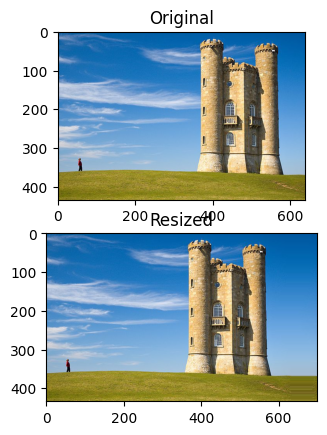

In [32]:
image = io.imread('/content/castle.jpg')
H, W, _ = image.shape

W_new = 700
energy = energy_function(image)

out = enlarge_naive(image, W_new, axis=1)
plt.subplot(211)
plt.title('Original')
plt.imshow(img)

plt.subplot(212)
plt.title('Resized')
plt.imshow(out)
plt.show()


In [33]:
def find_seams(image, k, axis=1, efunc=energy_function, cfunc=compute_cost):

	image = np.copy(image)
	if axis == 0:
		image = np.transpose(image, (1, 0, 2))
	H, W, C = image.shape
	assert W > k, "k must be smaller than %d" % W

	indices = np.tile(range(W), (H, 1))

	seams = np.zeros((H, W), dtype=type(image[0, 0, 0]))

	for i in range(k):
		energy = efunc(image)
		cost, paths = cfunc(image, energy)
		end = np.argmin(cost[H - 1])
		seam = backtrack_seam(paths, end)

		image = remove_seam(image, seam)


		assert np.all(seams[np.arange(H), indices[np.arange(H), seam]] == 0), \
			"we are overwriting seams"
		seams[np.arange(H), indices[np.arange(H), seam]] = i + 1

		indices = remove_seam(indices, seam)

	if axis == 0:
		seams = np.transpose(seams, (1, 0))
	return seams


In [34]:
def enlarge(image, size, axis=1, efunc=energy_function, cfunc=compute_cost):

	out = np.copy(image)
	if axis == 0:
		out = np.transpose(out, (1, 0, 2))
	H, W, C = out.shape

	assert size > W, "size must be greather than %d" % W

	assert size <= 2 * W, "size must be smaller than %d" % (2 * W)

	k = size - W
	seams = find_seams(out,k,efunc=energy_function,cfunc=compute_cost)
	temp = np.zeros((H,size,C), dtype=type(image[0, 0, 0]))
	for i in range(H):
		z = np.where(seams[i]>0)[0]
		dupe = []
		for j in z:
			dupe.append(out[i,j])
		temp[i] = np.insert(out[i],z,dupe,axis=0)
	out = np.copy(temp)

	if axis == 0:
		out = np.transpose(out, (1, 0, 2))

	return out


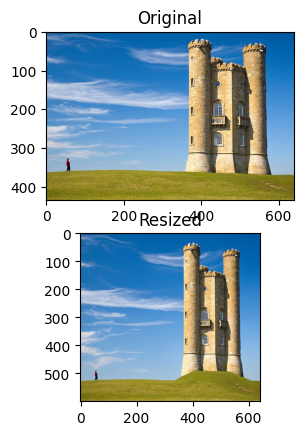

In [35]:
image = io.imread('/content/castle.jpg')
H, W, _ = image.shape

W_new = 600
energy = energy_function(image)

out = enlarge(image, W_new, axis=0)
plt.subplot(211)
plt.title('Original')
plt.imshow(img)

plt.subplot(212)
plt.title('Resized')
plt.imshow(out)
plt.show()